<a href="https://colab.research.google.com/github/RVS97/MNIST-GANs/blob/master/TCV2_DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries
Import required libraries

In [0]:
import sys
import json
import os
import glob
from tensorflow.python import keras
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.optimizers import Adam, SGD
from tensorflow.python.keras.models import Sequential, Model, load_model
from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda, Reshape
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Conv2DTranspose 
from tensorflow.python.keras.layers import Input, UpSampling2D, concatenate  
from tensorflow.python.keras.layers import LeakyReLU
import time
import tensorflow as tf
import numpy as np
import cv2
import random
from sklearn.utils import shuffle
from matplotlib import pyplot
from math import ceil
from scipy.stats import describe
from sklearn.model_selection import train_test_split
import time
import pickle
import datetime

# Dataset
Import MNIST dataset from keras and map image values to 0/1

In [0]:
# Import dataset
from keras.datasets import mnist

class MNISTdata:
  def __init__(self, batchSize=100, shuffle=True, vBatchNorm=False):
    
    # Load into variables
    (self.x_train, self.y_train),(self.x_test, self.y_test) = mnist.load_data()

    self.x_train = np.expand_dims(self.x_train, -1)
    self.x_test = np.expand_dims(self.x_test, -1)
    
    # Map image values to the range -1/1
    self.x_train = (self.x_train.astype(np.float32) - 127.5)/127.5*-1
    self.x_test = (self.x_test.astype(np.float32) - 127.5)/127.5*-1

    self.imgWidth = len(self.x_train[0][0])
    self.imgHeight = len(self.x_train[0])
    self.nTrainSamples = len(self.x_train)
    self.nTestSamples = len(self.x_test)
    
    print("MNIST loaded correctly")
    print(" - {} by {} images (grayscale)".format(self.imgWidth,self.imgHeight))
    print(" - {} training samples".format(self.nTrainSamples))
    print(" - {} test samples".format(self.nTestSamples))
    
    self.batchSize = batchSize
    self.nBatches = ceil(self.nTrainSamples/self.batchSize)
    
    print("Batch size {} -> {} batches".format(self.batchSize, self.nBatches))
    
    if shuffle: self.shuffleData()
      
    # Batch normalisation
    self.vBatchNorm = vBatchNorm
    
    if self.vBatchNorm:
      # NOT WORKING!
      stats = self.getVBatchStats()
      self.vBNMean = stats.mean
      self.vBNSTD = stats.variance
      
      self.x_train = self.x_train - self.vBNMean
      self.x_train = np.divide(self.x_train, np.sqrt(self.vBNSTD))
      
      self.x_val = self.x_val - self.vBNMean
      self.x_val = np.divide(self.x_val, np.sqrt(self.vBNSTD))
      
      self.x_test = self.x_test - self.vBNMean
      self.x_test = np.divide(self.x_test, np.sqrt(self.vBNSTD))
    
  def shuffleData(self):
    self.x_train, self.y_train = shuffle(self.x_train, self.y_train)
    
  def getVBatchStats(self):
    return describe(self.x_train[0:self.batchSize])
    
  def getBatch(self, batchId):
    if (batchId+1)*self.batchSize > self.nTrainSamples:
      batch = self.x_train[batchId*self.batchSize:]
    else:
      batch = self.x_train[batchId*self.batchSize:(batchId+1)*self.batchSize]
    return batch, np.ones((len(batch),))    
    
data = MNISTdata(batchSize = 200)

Using TensorFlow backend.


11493376/11490434 [==============================] - 0s 0us/step
MNIST loaded correctly
 - 28 by 28 images (grayscale)
 - 60000 training samples
 - 10000 test samples
Batch size 200 -> 300 batches


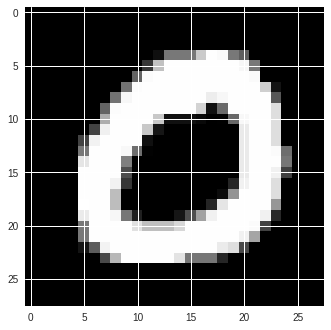

In [0]:
pyplot.imshow(data.x_train[0].reshape((28, 28)))

# Model Data

In [0]:
class modelData:
  def __init__(self, model, modelId='auto'):
    # Save model structure
    self.jsonStructure = model.to_json()
    
    # Set model id (defaut is timestamp of creation)
    if modelId == 'auto':
      self.modelId = self.setId()
    else:
      self.modelId = modelId
    
    # Set saved epoch counter to 0
    self.currentEpoch = 0
    self.epochsHist = {}
    
    self.params = {}
    
  def setId(self):
    return datetime.datetime.now().strftime("%d_%Hh_%Mm")
  
  def getId(self):
    return self.modelId
  
  def addEpochCheckpoint(self, model, hist):
    # Save weights
    self.currentEpoch += 1
    
    # Save history
    self.epochsHist[self.currentEpoch] = hist.history
    
    # Save model
    saveName = self.modelId + "_" + model.name + "_" + str(self.currentEpoch) + ".h5"
    model.save(saveName)
    return saveName
  
  def saveParams(self, **params):
    self.params.update(params)
    

# Google Drive Mount

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
rootDir = "/content/rootDir"

def saveFile(filePath, rootDir):
  !cp $filePath $rootDir
  
def getFile(fileName, rootDir, localDir = "./"):
  path = rootDir + "/" + fileName
  !cp $path $localDir

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Generator and Discriminator
Define generator and discriminator network

In [0]:
def getDiscriminator(inputShape=(28,28,1)):
  model = Sequential(name="Discriminator")
  model.add(Conv2D(32, (3, 3), strides=(2, 2), padding='same', input_shape=inputShape, kernel_initializer='glorot_uniform'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization(axis=-1))

  model.add(Conv2D(64, (3, 3), strides=(2, 2), padding='same', kernel_initializer='glorot_uniform'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization(axis=-1))

  model.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same', kernel_initializer='glorot_uniform'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization(axis=-1))

  model.add(Flatten())
  model.add(Dense(1, activation='sigmoid'))
  return model
  
def getDiscriminator2(inputShape=(28,28,1)):
  model = Sequential(name="Discriminator")
  model.add(Conv2D(32, (3, 3), strides=(2, 2), padding='same', input_shape=inputShape, kernel_initializer='glorot_uniform'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization(axis=-1))
  
  model.add(Conv2D(64, (3, 3), padding='same', input_shape=inputShape, kernel_initializer='glorot_uniform'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization(axis=-1))

  model.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same', kernel_initializer='glorot_uniform'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization(axis=-1))

  model.add(Conv2D(256, (3, 3), strides=(2, 2), padding='same', kernel_initializer='glorot_uniform'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(BatchNormalization(axis=-1))

  model.add(Flatten())
  model.add(Dense(1, activation='sigmoid'))
  return model

In [0]:
def getGenerator(inputShape=(100,)):
  model = Sequential(name="Generator")
  model.add(Dense(7*7*128, activation='relu', input_shape=inputShape, name='InputDense', kernel_initializer='glorot_uniform'))
  model.add(BatchNormalization(axis=-1))
  model.add(Reshape((7, 7, 128), name='InputReshape'))
  
  model.add(Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu', name='tConv1', kernel_initializer='glorot_uniform'))
  model.add(BatchNormalization(axis=-1))
  
  model.add(Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', activation='relu', name='tConv2', kernel_initializer='glorot_uniform'))
  model.add(BatchNormalization(axis=-1))
  
  model.add(Conv2D(1, (3, 3), padding='same', activation='tanh', name='outConv', kernel_initializer='glorot_uniform'))
  
  return model

def getGenerator2(inputShape=(100,)):
  model = Sequential(name="Generator")
  model.add(Dense(7*7*128, activation='relu', input_shape=inputShape, name='InputDense', kernel_initializer='glorot_uniform'))
  model.add(BatchNormalization(axis=-1))
  model.add(Reshape((7, 7, 128), name='InputReshape'))
  
  model.add(Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu', name='tConv1', kernel_initializer='glorot_uniform'))
  model.add(BatchNormalization(axis=-1))
  
  model.add(Conv2D(32, (3, 3), padding='same', activation='relu', name='tConv1', kernel_initializer='glorot_uniform'))
  model.add(BatchNormalization(axis=-1))
  
  model.add(Conv2DTranspose(16, (3, 3), strides=(2, 2), padding='same', activation='relu', name='tConv2', kernel_initializer='glorot_uniform'))
  model.add(BatchNormalization(axis=-1))
  
  model.add(Conv2D(1, (3, 3), padding='same', activation='tanh', name='outConv', kernel_initializer='glorot_uniform'))
  
  return model

In [0]:
def getNoise(size):
    return np.random.normal(size=size)

In [0]:
def trainDiscriminator(model, data, labels):
  # Reset optmizer state?
  
  # Return loss
  return model.fit(x=data, y=labels, verbose=0)

In [0]:
def trainGenerator(model, fakeData, labels):
  # Reset optimizer state?
  
  # Classify data with discriminator model
  loss = model.fit(x=fakeData, y=labels, verbose=0)
  
  return loss
  

# Training

In [0]:
class paramSearch:
  def  __init__(self, K, optTypes, learnRate, beta1):
    self.K = K
    self.optTypes = optTypes
    self.learnRate = learnRate
    self.beta1 = beta1
    
  def getParams(self):
    for k in self.K:
      for opt in self.optTypes:
        if opt == 'sgd':
          for lr in self.learnRate:
            yield k, opt, lr
        else:
          for b1 in self.beta1:
            yield k, opt, b1
    

In [0]:
noiseVecLength = 100

# pS = paramSearch(K=[1, 2, 3], optTypes=['sgd', 'adam'], learnRate=[0.0001, 0.00001], beta1=[0.5, 0.9])
pS = paramSearch(K=[1, 2, 3], optTypes=['sgd', 'adam'], learnRate=[0.0001, 0.00001], beta1=[0.5, 0.9])
for k, opt, param in pS.getParams():
  epochs = 15
  
  # Redefine models to clear
  disc = getDiscriminator()
  discData = modelData(disc)
  
  # Get generator
  gen = getGenerator()

  # Get complete GAN
  gan = Sequential(name="gan")
  gan.add(gen)
  gan.add(disc)
  ganData = modelData(gan, modelId=discData.getId())
  
  # Save K
  K = k
  
  # Chose optimiser
  if opt == 'sgd':
    optimiser = SGD(lr=param)
    discData.saveParams(optType='sgd', opt=optimiser.get_config())
  else:
    optimiser = Adam(lr=0.0002, beta_1=param, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    discData.saveParams(optType='adam', opt=optimiser.get_config())
  
  # Save config
  discData.saveParams(K=K)

  # Compile models
  disc.compile(optimizer=optimiser, loss='binary_crossentropy')
  discData.saveParams(loss=disc.loss)

  gan.layers[-1].trainable=False #Lock discriminator
  gan.compile(optimizer=optimiser, loss='binary_crossentropy')
  ganData.saveParams(loss=gan.loss)

  # Create folder where to save model
  subDir = rootDir + "/" + discData.getId()
  !mkdir $subDir

  # Epochs
  for e in range(epochs):
    
    print(str(e))
    
    # Shuffle batches
    data.shuffleData()
    
    # Iterations
    for iter in range(data.nBatches):
      for k in range(K):
        # Get real data
        realImages, realLabels = data.getBatch(iter)

        # Get noise data for discriminator
        noiseInput = getNoise((data.batchSize, noiseVecLength))
        fakeImages = gen.predict(noiseInput, batch_size=data.batchSize)
        fakeLabels = np.zeros((data.batchSize,))

        # Train discriminator
        allImages = np.concatenate((realImages, fakeImages))
        allLabels = np.concatenate((realLabels, fakeLabels))
        histDisc = trainDiscriminator(disc, allImages, allLabels)

      # Get noise data for generator
      noiseInput = getNoise((data.batchSize, noiseVecLength))
      fakeLabels = np.ones((data.batchSize,))

      # Train generator
      histGan = trainGenerator(gan, noiseInput, fakeLabels)
      
      if iter%200 == 0:
        print("Discriminator: {}  Generator: {}".format(histDisc.history['loss'], histGan.history['loss']))


    # Save discriminator
    savedDiscName = discData.addEpochCheckpoint(disc, histDisc)
    discDataName = discData.getId() + "_" + disc.name + "_data.pkl"
    with open(discDataName, 'wb') as f:
      pickle.dump(discData, f)

    saveFile(savedDiscName, subDir)
    saveFile(discDataName, subDir)

    # Save gan
    savedGanName = ganData.addEpochCheckpoint(gan, histGan)
    ganDataName = ganData.getId() + "_" + gan.name + "_data.pkl"
    with open(ganDataName, 'wb') as f:
      pickle.dump(ganData, f)

    saveFile(savedGanName, subDir)
    saveFile(ganDataName, subDir)
    
  
  
pyplot.subplots()
pyplot.imshow(np.squeeze(fakeImages[0]))

In [0]:
# Redefine models to clear
disc = getDiscriminator()

# Get generator
gen = getGenerator()

# Get complete GAN
gan = Sequential(name="gan")
gan.add(gen)
gan.add(disc)

#gan.set_weights(keras.models.load_model('./descriptor_61.h5').get_weights())
gan.set_weights(keras.models.load_model(tag + "_gan_15.h5").get_weights())

In [0]:
noiseVecLength = 100
noiseInput = getNoise((noiseVecLength, data.batchSize))
fakeImages = gen.predict(noiseInput.T, batch_size=data.batchSize)

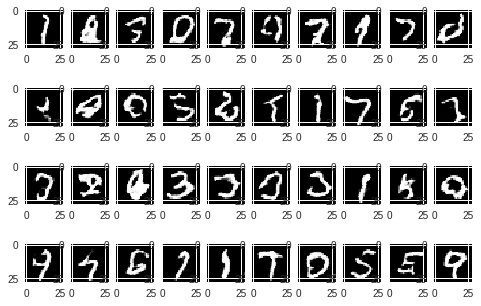

In [0]:
rows = 4
cols = 10

elems = random.sample(range(len(fakeImages)), rows*cols)

for j in range(rows):
  for i in range(cols):
    # equivalent but more general
    pyplot.subplot(rows, cols, j*cols + i + 1)
    pyplot.imshow(np.squeeze(fakeImages[elems[j*cols + i]]))

In [0]:
fakeLabels = np.zeros((data.batchSize,))
realImages, realLabels = data.getBatch(1)